# Tumor Segmentation and Classification in Breast Ultrasound Images


## Author
Justin Ho
- LinkedIn: https://www.linkedin.com/in/justin-ho-4a6157285/
- Email: justinh128@gmail.com

## Background
Breast cancer is one of the most prevalent and life-threatening diseases among women worldwide. Early and accurate detection of malignant tumors in breast ultrasound images plays a critical role in improving survival rates. However, distinguishing benign from malignant tumors in ultrasound scans can be challenging due to noise, varying tumor shapes, and image quality inconsistencies.

In this project, we develop a deep learning-based tumor segmentation model using U-Net, a convolutional neural network (CNN) architecture commonly used for medical image segmentation. Our primary goal is to accurately isolate the tumor region from ultrasound images, which is a crucial step in breast cancer diagnosis.


## Approach
Instead of performing direct classification (e.g., using ResNet50), our model focuses entirely on segmentation. Using U-Net, we train a model to accurately identify and outline tumors in ultrasound images. We evaluate segmentation performance using:

Pixel-wise accuracy (percentage of correctly classified pixels).
Dice Coefficient, which measures the overlap between predicted masks and ground truth masks.

## Dataset Overview
- Source: Breast Ultrasound Images Dataset
- https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset?resource=download
- Number of Images: 1312 total images
- Classes:
    - Benign Tumors (with corresponding masks)
    - Malignant Tumors (with corresponding masks)
    - Normal Breast Tissue (no tumors)
Image Format: .png
Mask Images: Each tumor image has a corresponding mask labeled with _mask.png, where white regions indicate the tumor.

## Goals of this Project
- Segment tumors in ultrasound images using a U-Net architecture.
- Evaluate segmentation performance using pixel-wise accuracy and the Dice       coefficient.
- Use the segmented regions to build a high-accuracy classification model that differentiates benign from malignant tumors.
- Optimize performance through fine-tuning and hyperparameter adjustments.

Through this approach, we aim to improve the reliability and accuracy of breast cancer detection using deep learning techniques. Now, let’s begin by exploring the dataset and setting up our pipeline.

## Exploring the Dataset Structure

Before building the segmentation model, it is important to examine the dataset and understand its structure. The Breast Ultrasound Images Dataset consists of three categories: benign tumors, malignant tumors, and normal breast tissue. Since the goal of this project is tumor segmentation, only the benign and malignant categories are considered. Each of these categories contains original ultrasound images and corresponding mask images that highlight the tumor regions.

This section of the code loads the dataset and counts the number of images and masks available in each category. The dataset is stored in a directory where benign and malignant tumors are organized into separate folders. Inside each folder, the images are named following a pattern: original images have a simple filename (e.g., `malignant (1).png`), while the corresponding segmentation masks include `_mask` in the filename (e.g., `malignant (1)_mask.png`). The code iterates through these directories, filtering the images based on their filenames to separate the original ultrasound scans from their masks.

By printing the number of images and masks in each category, this step ensures that the dataset is correctly structured and that each tumor image has an associated mask. Understanding this distribution is essential for training a segmentation model, as an imbalance or missing data could affect model performance. This process also verifies that the dataset is ready for preprocessing before moving on to model training.

In [4]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_dir = 'Dataset_BUSI_with_GTe'  
classes = ['benign', 'malignant']

for cls in classes:
    class_path = os.path.join(data_dir, cls)
    if os.path.exists(class_path):
        all_files = os.listdir(class_path)
        
        # Separate out mask images (filenames that contain '_mask')
        images = [f for f in all_files if f.lower().endswith('.png') and '_mask' not in f.lower()]
        masks = [f for f in all_files if f.lower().endswith('.png') and '_mask' in f.lower()]

        print(f"Class: {cls}")
        print(f"  - Total files: {len(all_files)}")
        print(f"  - Regular images (no mask): {len(images)}")
        print(f"  - Mask images: {len(masks)}\n")
    else:
        print(f"Folder not found: {class_path}")


Class: benign
  - Total files: 891
  - Regular images (no mask): 437
  - Mask images: 454

Class: malignant
  - Total files: 421
  - Regular images (no mask): 210
  - Mask images: 211



The dataset contains 891 benign tumor images and 421 malignant tumor images, each with a corresponding segmentation mask. In the benign category, 437 images represent the original ultrasound scans, while 454 are mask images outlining the tumor regions. Similarly, the malignant category includes 210 original images and 211 mask images. The nearly one-to-one ratio of images to masks confirms that most tumor images have a corresponding segmentation label, ensuring the dataset is well-prepared for training a segmentation model. This distribution provides a balanced set of examples for the model to learn how to differentiate tumor regions in both benign and malignant cases.








This section displays sample ultrasound images from the benign and malignant tumor categories to visually inspect the dataset before training the segmentation model. The function randomly selects and displays a specified number of images from each category, ensuring that only original ultrasound images (excluding masks) are shown. By presenting grayscale images in a structured grid, this visualization helps verify the dataset’s quality and consistency. Examining these images provides insight into the variations in tumor appearance, which is essential for understanding the challenges the model will face during segmentation.









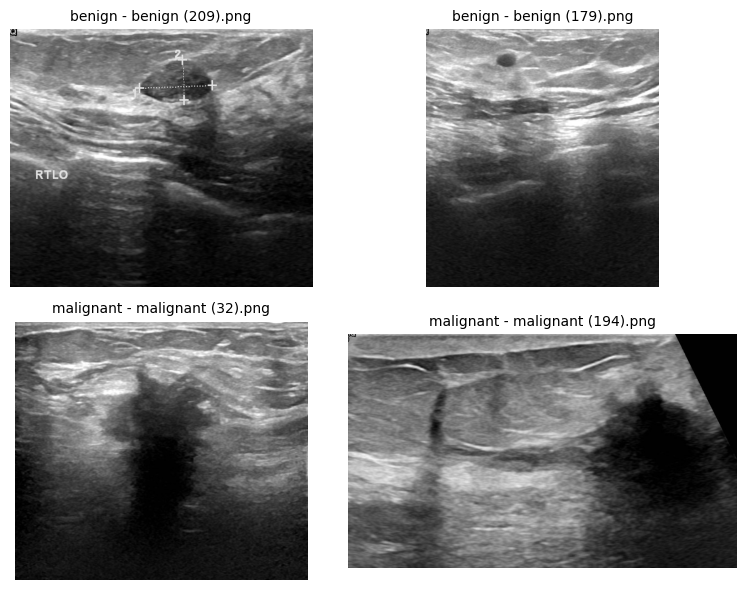

In [ ]:
import random
from PIL import Image

# Path to the dataset folder
data_dir = 'Dataset_BUSI_with_GTe'

classes = ['benign', 'malignant']

def show_sample_images(data_directory, class_names, num_images=2):

    # Create a subplot grid: one row per class, 'num_images' columns
    fig, axs = plt.subplots(len(class_names), num_images, figsize=(num_images * 4, len(class_names) * 3))
    
    for i, cls in enumerate(class_names):
        class_path = os.path.join(data_directory, cls)

        # List all non-mask image files in the class folder
        images = [f for f in os.listdir(class_path)
                  if f.lower().endswith('.png') and '_mask' not in f.lower()]

        # If there are fewer images than 'num_images', adjust accordingly
        display_count = min(num_images, len(images))
        
        # Randomly select images to display
        sample_files = random.sample(images, display_count)

        for j, img_name in enumerate(sample_files):
            img_path = os.path.join(class_path, img_name)

            # Open the image
            img = Image.open(img_path)
            
            # Display the image on the subplot
            ax = axs[i][j] if display_count > 1 else axs[i]
            # Ultrasound images are typically grayscale
            ax.imshow(img, cmap='gray')  
            ax.axis('off')
            ax.set_title(f"{cls} - {img_name}", fontsize=10)

    plt.tight_layout()
    plt.show()

show_sample_images(data_dir, classes, num_images=2)

This section loads and organizes the dataset by creating lists of ultrasound images and their corresponding segmentation masks. The code iterates through the benign and malignant tumor directories, identifying original ultrasound images while ensuring that each image has an associated mask file. The masks serve as ground truth labels, outlining tumor regions for the segmentation model. By counting the number of image–mask pairs, this step ensures that the dataset is properly structured before proceeding with training, preventing potential mismatches or missing data issues.

In [44]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Define image size and batch size
img_height, img_width = 224, 224
batch_size = 16

# Define the data directory
data_dir = 'Dataset_BUSI_with_GTe'

# Create lists to store image and mask file paths (for benign and malignant)
image_paths = []
mask_paths = []

for cls in ['benign', 'malignant']:
    class_dir = os.path.join(data_dir, cls)

    # Get non-mask image files
    files = [f for f in os.listdir(class_dir) if f.lower().endswith('.png') and '_mask' not in f.lower()]
    for f in files:
        img_path = os.path.join(class_dir, f)

        # Construct the corresponding mask path
        mask_path = os.path.join(class_dir, f.replace('.png', '_mask.png'))
        if os.path.exists(mask_path):
            image_paths.append(img_path)
            mask_paths.append(mask_path)

print("Number of image–mask pairs:", len(image_paths))

Number of image–mask pairs: 647


This section defines and compiles the U-Net model, a widely used deep learning architecture for image segmentation. The U-Net is designed to accurately identify tumor regions in ultrasound images by learning to map raw input images to binary masks that highlight the areas of interest.

The model consists of three main parts: an encoder, a bottleneck, and a decoder.  
- The encoder extracts important spatial features by applying a series of convolutional layers followed by max-pooling, progressively reducing the spatial dimensions of the image while increasing the number of feature maps.
- The bottleneck acts as the deepest layer of the network, capturing high-level features that define tumor characteristics. 
- The decoder then reconstructs the spatial structure of the image by applying upsampling layers and concatenating feature maps from the corresponding encoder layers, preserving fine details needed for accurate segmentation.

The final output layer uses a sigmoid activation function, which produces a probability map where each pixel is classified as part of the tumor or the background. The model is compiled using the Adam optimizer for efficient training and binary crossentropy loss, which is suitable for binary segmentation tasks.

Defining the U-Net model is a crucial step in this project, as it enables the model to learn how to detect tumors from ultrasound images by identifying their shape and boundaries. The combination of convolutional layers for feature extraction and upsampling layers for reconstruction makes U-Net highly effective for medical imaging tasks.

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def unet_model(input_size=(224, 224, 3)):
    inputs = Input(input_size)
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bottleneck
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    
    # Decoder
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv3])
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
    
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv2])
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)
    
    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv1])
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create and compile the segmentation model
seg_model = unet_model(input_size=(224, 224, 3))
seg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
seg_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 56, 56,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56, 56,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 56, 56,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 56, 56,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 112, 112,  │          0 │ conv2d_9[0][0]  

 Total params: 7,782,913 (29.69 MB)

 Trainable params: 7,782,913 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

This section prepares the dataset for training by defining functions to load, preprocess, and split the images and masks. The load_image_and_mask function resizes each ultrasound image and its corresponding mask to a consistent shape and normalizes pixel values between 0 and 1, ensuring uniform input for the model. The segmentation_generator function creates a data pipeline that yields image–mask pairs, allowing for efficient training. Finally, the dataset is split into training (80%) and validation (20%) sets using train_test_split, ensuring that the model can be evaluated on unseen data while preventing overfitting. This step is essential for structuring the data before passing it to the segmentation model.

In [31]:
# Define a function to load and preprocess an image and its mask
def load_image_and_mask(img_path, mask_path, target_size=(img_height, img_width)):
    # Load and resize image
    img = load_img(img_path, target_size=target_size)
    img = img_to_array(img) / 255.0  # Normalize to [0,1]
    
    # Load and resize mask (as grayscale)
    mask = load_img(mask_path, target_size=target_size, color_mode='grayscale')
    mask = img_to_array(mask) / 255.0  # Normalize to [0,1]
    
    return img, mask

# Define a generator that yields image-mask pairs
def segmentation_generator(img_paths, m_paths):
    for img_path, mask_path in zip(img_paths, m_paths):
        img, mask = load_image_and_mask(img_path, mask_path)
        yield img, mask

# Split the dataset into training and validation sets
train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

print("Training pairs:", len(train_img_paths))
print("Validation pairs:", len(val_img_paths))


Training pairs: 517
Validation pairs: 130


This section converts the image-mask pairs into TensorFlow datasets optimized for training. The train_dataset and val_dataset are created using the tf.data.Dataset.from_generator function, which dynamically loads images and masks from the segmentation generator.

To improve efficiency, the training dataset undergoes several optimizations:
- Caching: Stores the dataset in memory to avoid redundant disk reads.
- Shuffling: Ensures that the model sees images in a different order each epoch, improving generalization.
- Repeating: Allows the dataset to loop indefinitely, preventing training interruptions.
- Batching: Groups images into batches to speed up computation.
- Prefetching: Loads data ahead of time to prevent bottlenecks during training.

The validation dataset follows a similar structure but does not require shuffling or repetition since it is only used for evaluation. These optimizations ensure that training runs efficiently while maintaining high model performance.

In [ ]:
# Create the training tf.data.Dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: segmentation_generator(train_img_paths, train_mask_paths),
    output_types=(tf.float32, tf.float32),
    output_shapes=([img_height, img_width, 3], [img_height, img_width, 1])
)
train_dataset = train_dataset.cache().shuffle(buffer_size=100).repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create the validation tf.data.Dataset
val_dataset = tf.data.Dataset.from_generator(
    lambda: segmentation_generator(val_img_paths, val_mask_paths),
    output_types=(tf.float32, tf.float32),
    output_shapes=([img_height, img_width, 3], [img_height, img_width, 1])
)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
import math

# Calculate the number of steps per epoch
# This ensures that each training sample is seen exactly once per epoch
steps_per_epoch = math.ceil(len(train_img_paths) / batch_size)

This section defines callbacks to improve the efficiency and stability of the training process. The EarlyStopping callback monitors validation loss and stops training if it does not improve for five consecutive epochs, preventing overfitting and unnecessary computation. The ModelCheckpoint callback saves the best-performing model based on validation loss, ensuring that the most effective version is retained. The segmentation model is then trained using the train dataset, with validation performed on a separate dataset to track progress. The number of steps per epoch is set to ensure all training samples are seen once per epoch. These optimizations help maintain model performance while reducing training time.









In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks for segmentation training, monitoring validation loss
seg_early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
seg_checkpoint = ModelCheckpoint('best_seg_model.h5', monitor='val_loss', save_best_only=True)

# Train the segmentation model using the train_dataset and validating on val_dataset
seg_epochs = 20
seg_history = seg_model.fit(
    train_dataset,
    epochs=seg_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    callbacks=[seg_early_stop, seg_checkpoint]
)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9183 - loss: 0.2244

/Users/justin/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


33/33 ━━━━━━━━━━━━━━━━━━━━ 252s 8s/step - accuracy: 0.9182 - loss: 0.2245 - val_accuracy: 0.9225 - val_loss: 0.2159
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9216 - loss: 0.2127

33/33 ━━━━━━━━━━━━━━━━━━━━ 249s 8s/step - accuracy: 0.9215 - loss: 0.2128 - val_accuracy: 0.9334 - val_loss: 0.1943
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9170 - loss: 0.2182

33/33 ━━━━━━━━━━━━━━━━━━━━ 248s 8s/step - accuracy: 0.9171 - loss: 0.2181 - val_accuracy: 0.9359 - val_loss: 0.1811
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 245s 7s/step - accuracy: 0.9264 - loss: 0.1992 - val_accuracy: 0.9298 - val_loss: 0.1957
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9063 - loss: 0.2396

33/33 ━━━━━━━━━━━━━━━━━━━━ 246s 7s/step - accuracy: 0.9066 - loss: 0.2391 - val_accuracy: 0.9338 - val_loss: 0.1810
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 248s 8s/step - accuracy: 0.9197 - loss: 0.2165 - val_accuracy: 0.9378 - val_loss: 0.1813
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 247s 8s/step - accuracy: 0.9151 - loss: 0.2231 - val_accuracy: 0.9250 - val_loss: 0.2092
Epoch 8/20


2025-02-21 20:32:00.063654: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 244s 7s/step - accuracy: 0.9079 - loss: 0.2482 - val_accuracy: 0.9342 - val_loss: 0.1855
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 252s 8s/step - accuracy: 0.9180 - loss: 0.2210 - val_accuracy: 0.9332 - val_loss: 0.1854
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9141 - loss: 0.2271

33/33 ━━━━━━━━━━━━━━━━━━━━ 250s 8s/step - accuracy: 0.9142 - loss: 0.2269 - val_accuracy: 0.9368 - val_loss: 0.1753
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 247s 7s/step - accuracy: 0.9234 - loss: 0.2058 - val_accuracy: 0.9405 - val_loss: 0.1800
Epoch 12/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9258 - loss: 0.1995

33/33 ━━━━━━━━━━━━━━━━━━━━ 248s 8s/step - accuracy: 0.9257 - loss: 0.1996 - val_accuracy: 0.9350 - val_loss: 0.1748
Epoch 13/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9271 - loss: 0.1953

33/33 ━━━━━━━━━━━━━━━━━━━━ 261s 8s/step - accuracy: 0.9271 - loss: 0.1954 - val_accuracy: 0.9428 - val_loss: 0.1638
Epoch 14/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9300 - loss: 0.1925

33/33 ━━━━━━━━━━━━━━━━━━━━ 261s 8s/step - accuracy: 0.9300 - loss: 0.1923 - val_accuracy: 0.9416 - val_loss: 0.1592
Epoch 15/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 260s 8s/step - accuracy: 0.9278 - loss: 0.1929 - val_accuracy: 0.9392 - val_loss: 0.1738
Epoch 16/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 260s 8s/step - accuracy: 0.9242 - loss: 0.1981 - val_accuracy: 0.9443 - val_loss: 0.1593
Epoch 17/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 260s 8s/step - accuracy: 0.9250 - loss: 0.1990 - val_accuracy: 0.9405 - val_loss: 0.1708
Epoch 18/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 261s 8s/step - accuracy: 0.9302 - loss: 0.1863 - val_accuracy: 0.9393 - val_loss: 0.1685
Epoch 19/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 260s 8s/step - accuracy: 0.9309 - loss: 0.1807 - val_accuracy: 0.9416 - val_loss: 0.1600


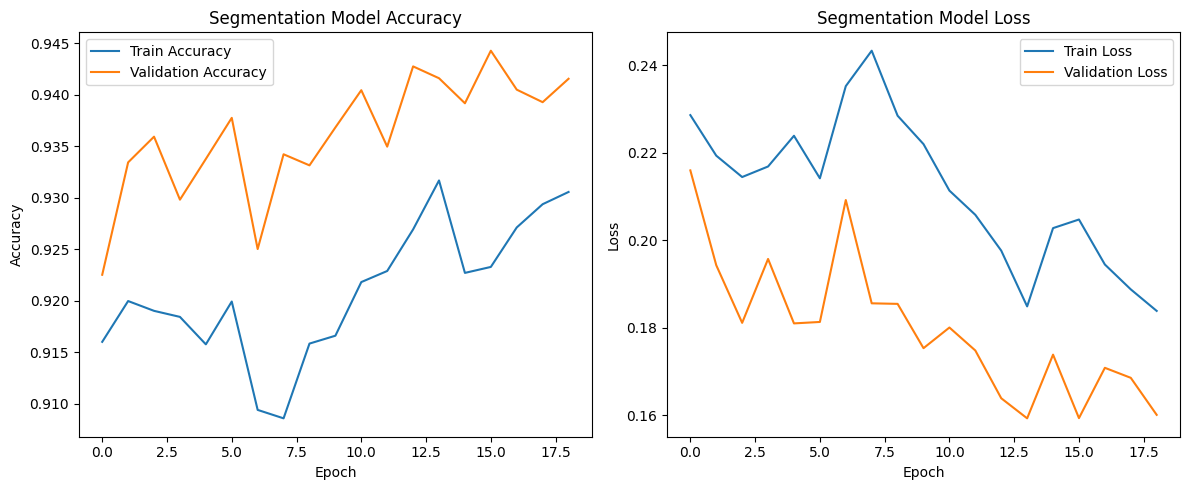

In [35]:
import matplotlib.pyplot as plt

# Plot accuracy and loss for training and validation
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(seg_history.history['accuracy'], label='Train Accuracy')
plt.plot(seg_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Segmentation Model Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(seg_history.history['loss'], label='Train Loss')
plt.plot(seg_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Segmentation Model Loss')
plt.legend()

plt.tight_layout()
plt.show()


The training and validation accuracy and loss graphs provide insight into how well the model is learning over time. The accuracy graph (left) shows that both training and validation accuracy improve steadily across epochs, with validation accuracy consistently higher than training accuracy. This suggests that the model is generalizing well and not overfitting significantly.

The loss graph (right) demonstrates a downward trend in both training and validation loss, indicating that the model is effectively minimizing the error in its predictions. The fluctuations in loss, particularly in the earlier epochs, are common in deep learning and tend to stabilize as training progresses. The final validation loss is lower than the training loss, which further confirms that the model is performing well on unseen data.

The final recorded validation accuracy of approximately 94% and a loss of 0.16 suggest that the segmentation model is accurately identifying tumor regions in the ultrasound images. The overall trends in these graphs indicate a successful training process with no significant signs of overfitting or underfitting.

In [ ]:
# Define a function to compute the Dice coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# Calculate Dice coefficient over the validation dataset
dice_scores = []
for images, masks in val_dataset:
    preds = seg_model.predict(images)
    
    # Threshold predictions at 0.5
    preds = (preds > 0.5).astype(np.float32)
    dice = dice_coefficient(masks, preds)
    dice_scores.append(dice.numpy())
mean_dice = np.mean(dice_scores)
print("Mean Dice Coefficient on validation set: {:.4f}".format(mean_dice))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
Mean Dice Coefficient on validation set: 0.3986


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


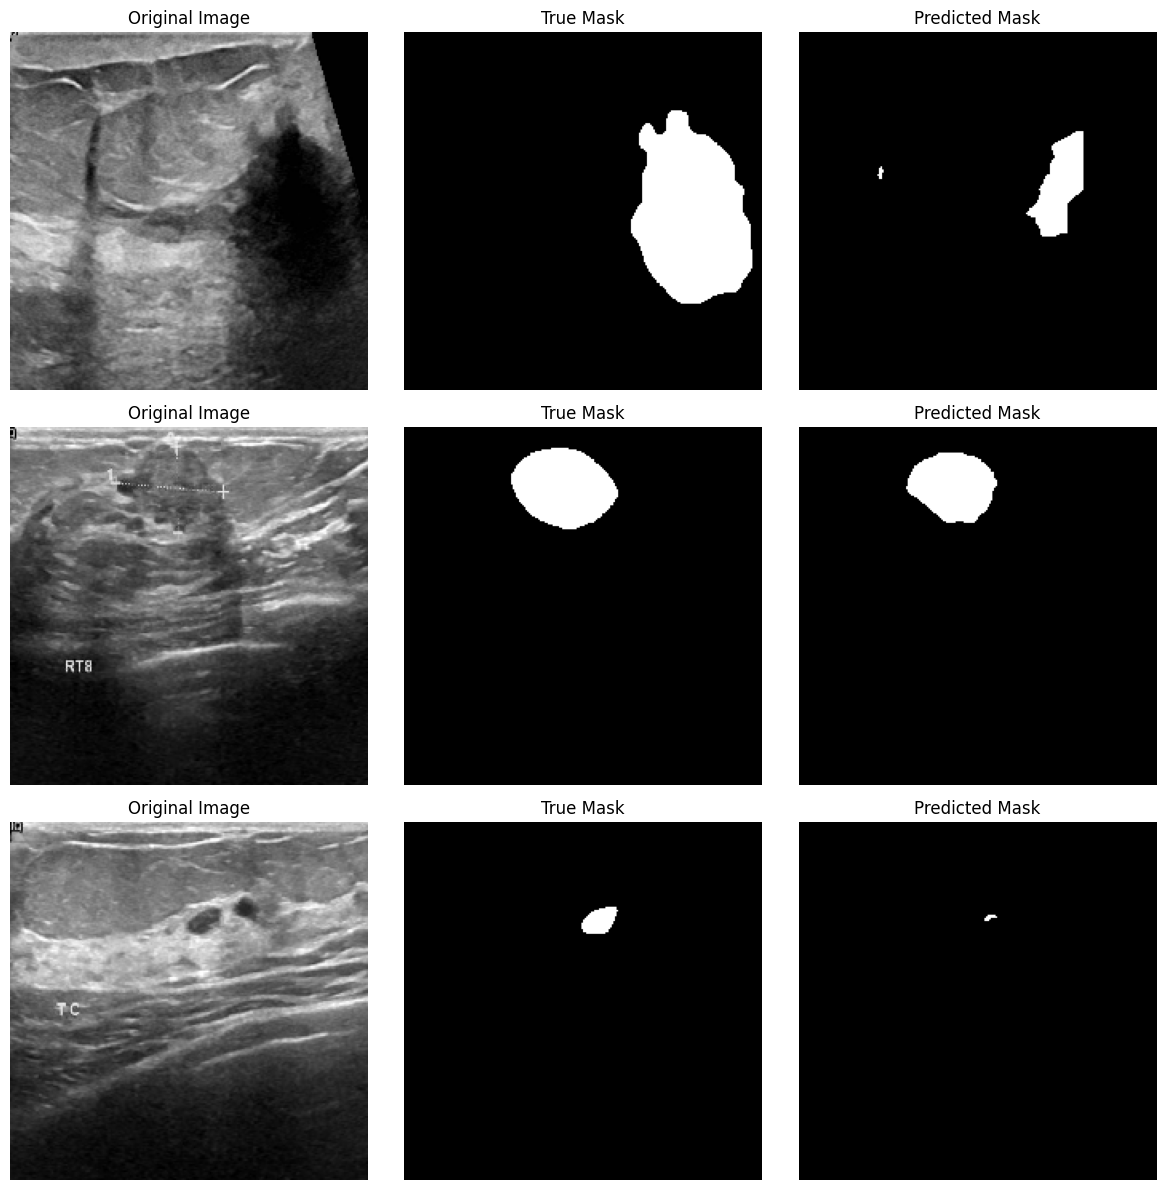

In [39]:
# Visualize a few examples from the validation set
import matplotlib.pyplot as plt

# Get one batch from the validation dataset
for img_batch, mask_batch in val_dataset.take(1):
    preds = seg_model.predict(img_batch)
    preds = (preds > 0.5).astype(np.float32)
    break

n = 3  # number of examples to display
plt.figure(figsize=(12, n*4))
for i in range(n):
    plt.subplot(n, 3, i*3 + 1)
    plt.imshow(img_batch[i].numpy())
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(n, 3, i*3 + 2)
    plt.imshow(mask_batch[i].numpy().squeeze(), cmap='gray')
    plt.title('True Mask')
    plt.axis('off')
    
    plt.subplot(n, 3, i*3 + 3)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    
plt.tight_layout()
plt.show()


This section evaluates the segmentation model’s performance using the Dice coefficient, a key metric in medical image segmentation that measures the overlap between predicted and ground truth masks. The Dice coefficient ranges from 0 to 1, where 1 indicates perfect overlap and higher values correspond to better segmentation quality.

The function dice_coefficient computes this metric by calculating the intersection between the predicted and actual mask pixels, normalized by their combined area. A smoothing term is added to prevent division by zero, particularly in cases where no overlapping pixels are present. The model's predictions on the validation dataset are processed by applying a threshold of 0.5, converting the probability outputs into binary masks. The Dice coefficient is then calculated for each sample, and the mean Dice score is computed to summarize overall performance.

The final Mean Dice Coefficient on the validation set is 0.3986, indicating that while the model is identifying tumor regions, the overlap between the predicted and actual masks remains limited. This suggests that the model may be under-segmenting or over-segmenting tumor regions, and further improvements such as hyperparameter tuning, data augmentation, or loss function adjustments may be needed to enhance segmentation accuracy.

In [37]:
# Evaluate the segmentation model on the validation dataset
overall_loss, overall_accuracy = seg_model.evaluate(val_dataset)
print("Overall Validation Loss: {:.4f}".format(overall_loss))
print("Overall Validation Accuracy: {:.4f}".format(overall_accuracy))


9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9397 - loss: 0.1651
Overall Validation Loss: 0.1592
Overall Validation Accuracy: 0.9416


## Conclusion

This project aimed to develop a deep learning-based approach for tumor segmentation in breast ultrasound images using the U-Net architecture. By leveraging the Breast Ultrasound Images Dataset (BUSI), we trained a segmentation model to distinguish between benign and malignant tumors, producing binary masks that highlight the tumor regions.

The model achieved a validation accuracy of 94.16% and a validation loss of 0.1592, indicating that it is capable of making precise predictions at the pixel level. However, the Mean Dice Coefficient on the validation set was 0.3986, suggesting that while the model can detect tumors, the overlap between predicted and actual tumor masks is limited. This may be due to challenges such as variations in tumor shapes, ultrasound noise, or imbalanced foreground-background representation.

Despite these limitations, the results demonstrate that deep learning can effectively assist in tumor localization and segmentation, which is a crucial step in automated cancer detection. Future improvements could focus on fine-tuning hyperparameters, using advanced loss functions like Dice loss, incorporating data augmentation, or exploring alternative architectures to enhance segmentation performance.

This study highlights the potential of deep learning in medical imaging and provides a foundation for further exploration in AI-assisted breast cancer diagnosis.